In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.colors import LogNorm
import cmocean as cmo
import xarray as xr 
import cartopy
import cartopy.crs as ccrs
from scipy.interpolate import interp1d
from tqdm import tqdm

In [2]:
# LOAD MODES 
mode_path = '/Users/jakesteinberg/Documents/CPT/vertical_structure/CM_comparisons/selected_modes_cmN_2deg.nc'
data_modes = xr.open_dataset(mode_path)
lon_in = data_modes.longitude.data
lat_in = data_modes.latitude.data 
z_mode = np.flip(data_modes.z.data)

In [3]:
# LOAD SURFACE VEL
u_path = '/Users/jakesteinberg/Documents/CPT/models/CM2.6_u_1year.nc'
u_data = xr.open_dataset(u_path)
lon01 = u_data.xu_ocean.data
u_full = np.concatenate((u_data.u_full[:,:,:,lon01 >= 0].data, u_data.u_full[:,:,:,lon01 < 0].data),axis=3)
lon1 = np.concatenate((lon01[lon01 >= 0], lon01[lon01 < 0]+360))
lat1 = u_data.yu_ocean.data

In [4]:
np.shape(u_full)

(73, 50, 270, 360)

In [5]:
z = -1*u_data.st_ocean.data

In [19]:
# extract surface velocity and bottom velocity on modes grid 
skill = np.nan*np.ones(np.shape(data_modes.modes[:,:,0].data))
dep_recon_eval = np.nan*np.ones(np.shape(data_modes.modes[:,:,0].data))
bottom_recon_u_out = np.nan*np.ones((len(lat_in), len(lon_in), np.shape(u_full)[0]))
bottom_obs_u_out = np.nan*np.ones((len(lat_in), len(lon_in), np.shape(u_full)[0]))
dep_obs_eval = np.nan*np.ones(np.shape(data_modes.modes[:,:,0].data))
for i in range(len(lat_in)):
    for j in range(len(lon_in)):
        this_lon = lon_in[j]
        this_lat = lat_in[i]
        lon2 = np.where((lon1 > (this_lon-1)) & (lon1 < (this_lon+1)))[0]
        lat2 = np.where((lat1 > (this_lat-1)) & (lat1 < (this_lat+1)))[0]
        this_u = np.nanmean(np.nanmean(u_full[:,:,lat2][:,:,:,lon2],axis=2),axis=2)
        this_u = this_u - np.tile(np.nanmean(this_u,axis=0)[None,:],(np.shape(this_u)[0],1))
        this_mode = np.flip(data_modes.modes[i,j,:].data)
        
        if len(np.where(~np.isnan(this_mode))[0]) < 5:
            continue
        
        # -- scale mode by near-surface velocities (average over top 6 indices = top 50 m)
        surf_u = np.nanmean(this_u[:,0:6],axis=1)
        # align with shallowest non-zero mode amp.
        this_recon = np.tile(this_mode,(np.shape(this_u)[0],1))*np.tile(surf_u[:,None]/this_mode[1],(1,len(z)))
        
        # index above desired depth to compute skill 
        z_i = 26 # 26,36
        indi = 1 # 4
        # -- deepest reconstructed velocity 
        # good_z = z_mode[np.where(~np.isnan(this_recon[0,:]))[0]]
        good_z = z_mode[z_i]
        bottom_i = np.where(z_mode == np.nanmax(good_z))[0][0]  # some bit off bottom 
        bottom_recon_u = np.nanmean(this_recon[:,bottom_i-indi:bottom_i-indi+2],axis=1)
        bottom_recon_u_out[i,j,:] = bottom_recon_u
        dep_recon_eval[i,j] = z_mode[bottom_i-0]
        # -- deepest 'actual' velocity
        # bottom_i = np.where(~np.isnan(this_u[0,:]))[0][-1] # some bit off bottom  
        bottom_i = z_i
        bottom_obs_u = np.nanmean(this_u[:,bottom_i-indi:bottom_i-indi+2],axis=1)
        bottom_obs_u_out[i,j,:] = bottom_obs_u
        dep_obs_eval[i,j] = z[bottom_i-0]
        skill[i,j] = 1 - np.nanvar(bottom_recon_u - bottom_obs_u)/np.nanvar(bottom_obs_u)

/Users/jakesteinberg/anaconda3/envs/cpt/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]
/Users/jakesteinberg/anaconda3/envs/cpt/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  


In [18]:
z_mode[36]
z[24]

-618.703125

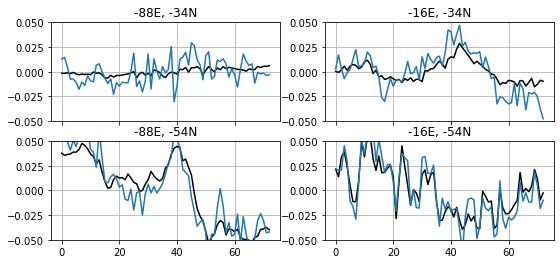

In [21]:
i1 = 20; j1 = 5;
i2 = 20; j2 = 41;
i3 = 10; j3 = 5;
i4 = 10; j4 = 41;
f, ax = plt.subplots(2,2,figsize=(9,4))
ax[0,0].plot(range(0,len(bottom_obs_u)),bottom_obs_u_out[i1,j1,:], color='k')
ax[0,0].plot(range(0,len(bottom_recon_u)),bottom_recon_u_out[i1,j1,:])
ax[0,0].set_title(str(lon_in[j1]-360) + 'E, ' + str(lat_in[i1]) + 'N')
ax[0,0].set_xticklabels('')
ax[0,0].set_ylim([-0.05,0.05])
ax[0,0].grid()

ax[0,1].plot(range(0,len(bottom_obs_u)),bottom_obs_u_out[i2,j2,:], color='k')
ax[0,1].plot(range(0,len(bottom_recon_u)),bottom_recon_u_out[i2,j2,:])
ax[0,1].set_title(str(lon_in[j2]-360) + 'E, ' + str(lat_in[i2]) + 'N')
ax[0,1].set_xticklabels('')
ax[0,1].set_ylim([-0.05,0.05])
ax[0,1].grid()

ax[1,0].plot(range(0,len(bottom_obs_u)),bottom_obs_u_out[i3,j3,:], color='k')
ax[1,0].plot(range(0,len(bottom_recon_u)),bottom_recon_u_out[i3,j3,:])
ax[1,0].set_title(str(lon_in[j3]-360) + 'E, ' + str(lat_in[i3]) + 'N')
ax[1,0].set_ylim([-0.05,0.05])
ax[1,0].grid()

ax[1,1].plot(range(0,len(bottom_obs_u)),bottom_obs_u_out[i4,j4,:], color='k')
ax[1,1].plot(range(0,len(bottom_recon_u)),bottom_recon_u_out[i4,j4,:])
ax[1,1].set_title(str(lon_in[j4]-360) + 'E, ' + str(lat_in[i4]) + 'N')
ax[1,1].set_ylim([-0.05,0.05])
ax[1,1].grid()
# f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2022_06_14/mode_skill_2_site_time.jpg', dpi=300)

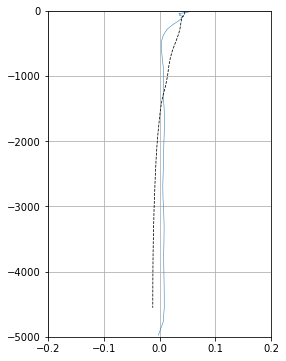

In [9]:
f, ax = plt.subplots(1,1,figsize=(4,6))
for i in range(0,1):
    ax.plot(this_u[i,:],z,linewidth=0.5)
    ax.plot(this_recon[i,:],z,color='k',linestyle='--',linewidth=0.76)
ax.set_xlim([-.2,.2])
ax.set_ylim([-5000,0])
ax.grid()

/Users/jakesteinberg/anaconda3/envs/cpt/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/jakesteinberg/anaconda3/envs/cpt/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


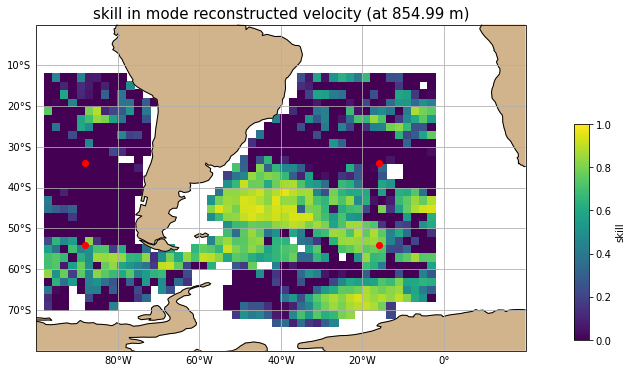

In [22]:
f, ax = plt.subplots(1,1,figsize=(10,6), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
cmap = plt.get_cmap('viridis')
cc = ax.pcolor(lon_in,lat_in,skill,cmap=cmap,vmin=0,vmax=1,transform=ccrs.PlateCarree())
ax.scatter(lon_in[j1],lat_in[i1], color='r',transform=ccrs.PlateCarree())
ax.scatter(lon_in[j2],lat_in[i2], color='r',transform=ccrs.PlateCarree())
ax.scatter(lon_in[j3],lat_in[i3], color='r',transform=ccrs.PlateCarree())
ax.scatter(lon_in[j4],lat_in[i4], color='r',transform=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax.coastlines(); gl = ax.gridlines(draw_labels=True)
ax.set_title('skill in mode reconstructed velocity (at ' + str(np.round(np.nanmean(dep_recon_eval),2)) + ' m)',fontsize=15)
gl.xlabels_top = False; gl.ylabels_right = False
ax.set_xlim([-100,20])
ax.set_ylim([-80,0])
cbpos = [0.92, 0.15, 0.02, 0.5]; cax = f.add_axes(cbpos); 
cb = f.colorbar(cc, cax=cax, orientation='vertical', label='skill')
# cb.set_label(label='slope [m/m]', color='k', fontsize=11)
# f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2022_06_14/mode_skill_2_w_sites.jpg', dpi=300)

In [144]:
np.nanmax(skill)

0.684494190596534